Preprocessing

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# load the dataset
data = pd.read_csv('/content/EEG.machinelearing_data_BRMH.csv')

# extract relevant columns
# identify EEG feature columns by checking column patterns
eeg_feature_columns = [col for col in data.columns if "AB." in col or "COH." in col]
label_column = "main.disorder"  # main disorder column
metadata_columns = ["sex", "age", "education", "IQ"]  # optional additional information

# split features and labels
X = data[eeg_feature_columns].values  # EEG features
y = data[label_column].values  # main disorder labels

# normalise EEG features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# encode categorical labels
encoder = OneHotEncoder(sparse_output=False)  # use sparse_output for newer versions
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.2, random_state=42)

# print data shapes for verification
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (756, 1140), y_train shape: (756, 7)
X_test shape: (189, 1140), y_test shape: (189, 7)


Define the Conditional VAE Model

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# define latent space dimensions
input_dim = X_train.shape[1]  # number of EEG features
latent_dim = 10  # adjustable parameter
condition_dim = y_train.shape[1]  # number of one-hot encoded labels

# encoder
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.encoder_layer = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
        ])
        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.encoder_layer(inputs)
        return self.z_mean(x), self.z_log_var(x)

# decoder
class Decoder(Model):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decoder_layer = tf.keras.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(output_dim, activation='sigmoid'),
        ])

    def call(self, z):
        return self.decoder_layer(z)

# conditional VAE with reparameterisation trick
class CVAE(Model):
    def __init__(self, latent_dim, input_dim, condition_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim + condition_dim, input_dim)
        self.latent_dim = latent_dim

    def sample(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], self.latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs, labels):
        conditioned_input = tf.concat([inputs, labels], axis=1)
        z_mean, z_log_var = self.encoder(conditioned_input)
        z = self.sample(z_mean, z_log_var)
        conditioned_z = tf.concat([z, labels], axis=1)
        reconstructed = self.decoder(conditioned_z)
        return reconstructed, z_mean, z_log_var

# instantiate the model
cvae = CVAE(latent_dim=latent_dim, input_dim=input_dim, condition_dim=condition_dim)

Loss Function and Training

In [15]:
# dfine loss function
def vae_loss(x, reconstructed, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(x, reconstructed))
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# training step
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        reconstructed, z_mean, z_log_var = cvae(inputs, labels)
        loss = vae_loss(inputs, reconstructed, z_mean, z_log_var)
    gradients = tape.gradient(loss, cvae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, cvae.trainable_variables))
    return loss

# training loop
epochs = 50
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)

for epoch in range(epochs):
    for inputs, labels in train_dataset:
        loss = train_step(inputs, labels)
    print(f"Epoch {epoch + 1}, Loss: {loss.numpy():.4f}")


Epoch 1, Loss: 1.2944
Epoch 2, Loss: 1.0809
Epoch 3, Loss: 1.0689
Epoch 4, Loss: 1.0703
Epoch 5, Loss: 1.0655
Epoch 6, Loss: 1.0644
Epoch 7, Loss: 1.0652
Epoch 8, Loss: 1.0644
Epoch 9, Loss: 1.0639
Epoch 10, Loss: 1.0652
Epoch 11, Loss: 1.0640
Epoch 12, Loss: 1.0641
Epoch 13, Loss: 1.0648
Epoch 14, Loss: 1.0635
Epoch 15, Loss: 1.0662
Epoch 16, Loss: 1.0668
Epoch 17, Loss: 1.0672
Epoch 18, Loss: 1.0649
Epoch 19, Loss: 1.0654
Epoch 20, Loss: 1.0646
Epoch 21, Loss: 1.0654
Epoch 22, Loss: 1.0644
Epoch 23, Loss: 1.0653
Epoch 24, Loss: 1.0644
Epoch 25, Loss: 1.0645
Epoch 26, Loss: 1.0641
Epoch 27, Loss: 1.0639
Epoch 28, Loss: 1.0655
Epoch 29, Loss: 1.0671
Epoch 30, Loss: 1.0657
Epoch 31, Loss: 1.0643
Epoch 32, Loss: 1.0623
Epoch 33, Loss: 1.0630
Epoch 34, Loss: 1.0719
Epoch 35, Loss: 1.0696
Epoch 36, Loss: 1.0668
Epoch 37, Loss: 1.0728
Epoch 38, Loss: 1.0657
Epoch 39, Loss: 1.0655
Epoch 40, Loss: 1.0656
Epoch 41, Loss: 1.0648
Epoch 42, Loss: 1.0628
Epoch 43, Loss: 1.0656
Epoch 44, Loss: 1.06

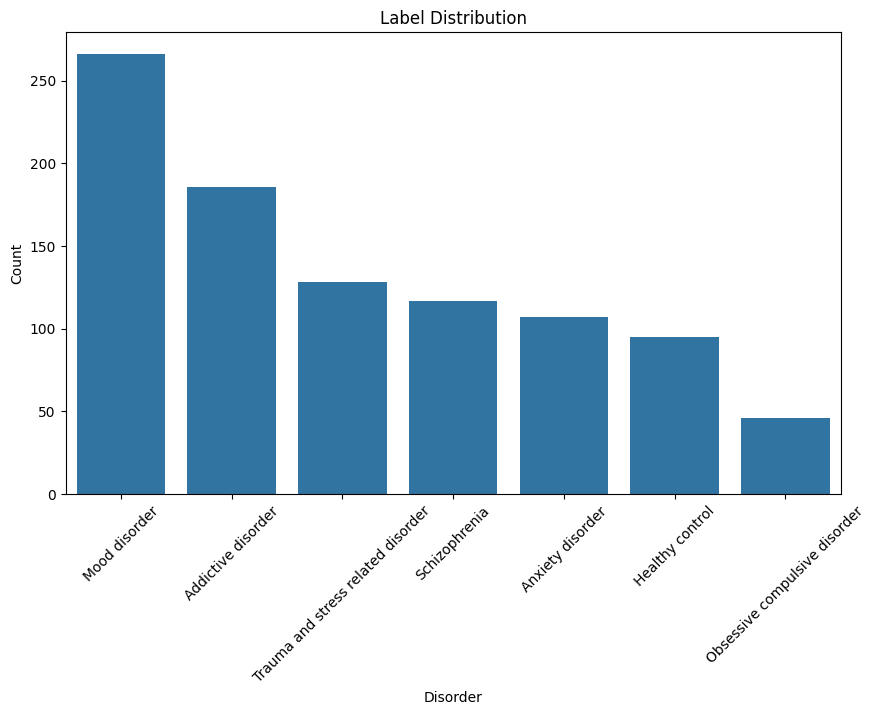

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# `data['main.disorder']` contains labels
label_counts = data['main.disorder'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Label Distribution")
plt.xlabel("Disorder")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


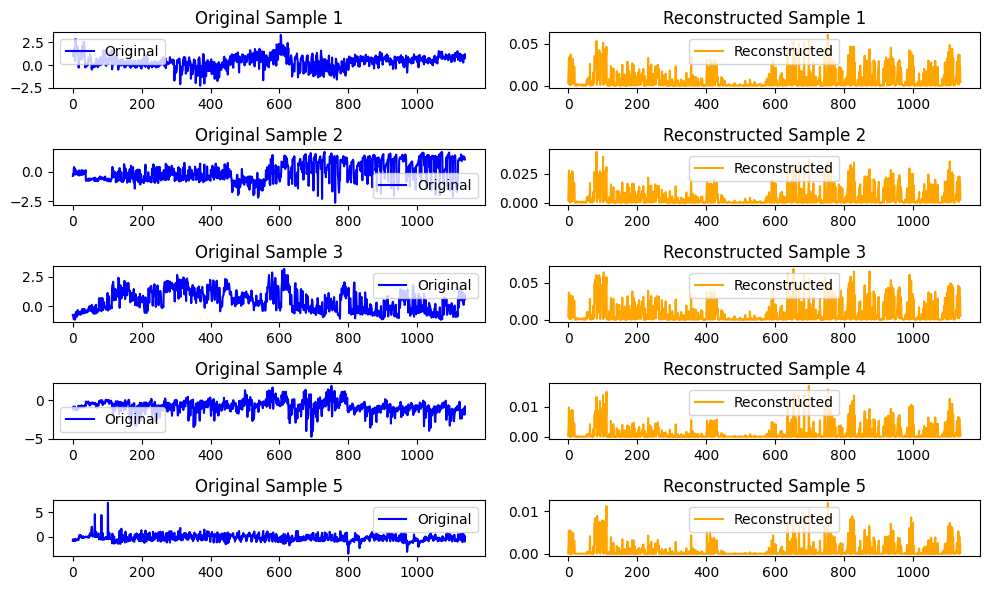

In [17]:
# plot original vs reconstructed features
plt.figure(figsize=(10, 6))
for i in range(5):  # Show 5 samples
    plt.subplot(5, 2, i*2 + 1)
    plt.plot(original[i], label="Original", color="blue")
    plt.legend()
    plt.title(f"Original Sample {i+1}")

    plt.subplot(5, 2, i*2 + 2)
    plt.plot(reconstructed[i], label="Reconstructed", color="orange")
    plt.legend()
    plt.title(f"Reconstructed Sample {i+1}")

plt.tight_layout()
plt.show()


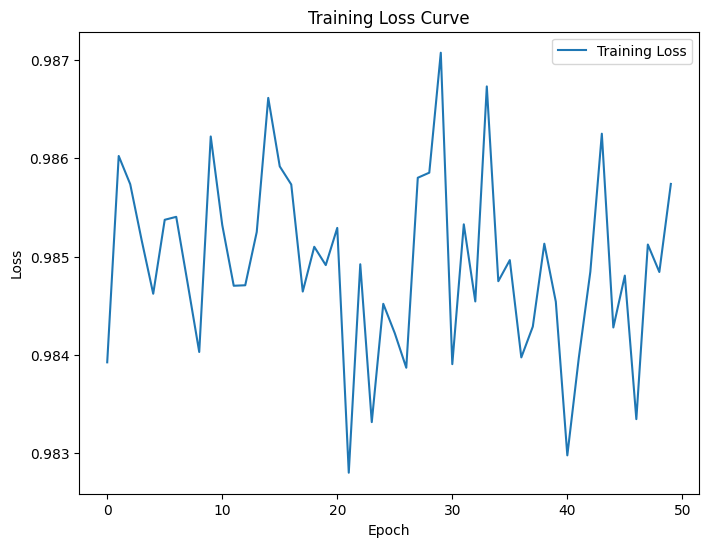

In [18]:
losses = []

# during training, append the loss after each epoch
for epoch in range(epochs):
    epoch_loss = 0
    for inputs, labels in train_dataset:
        loss = train_step(inputs, labels)
        epoch_loss += loss.numpy()
    losses.append(epoch_loss / len(train_dataset))

# plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(losses, label="Training Loss")
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


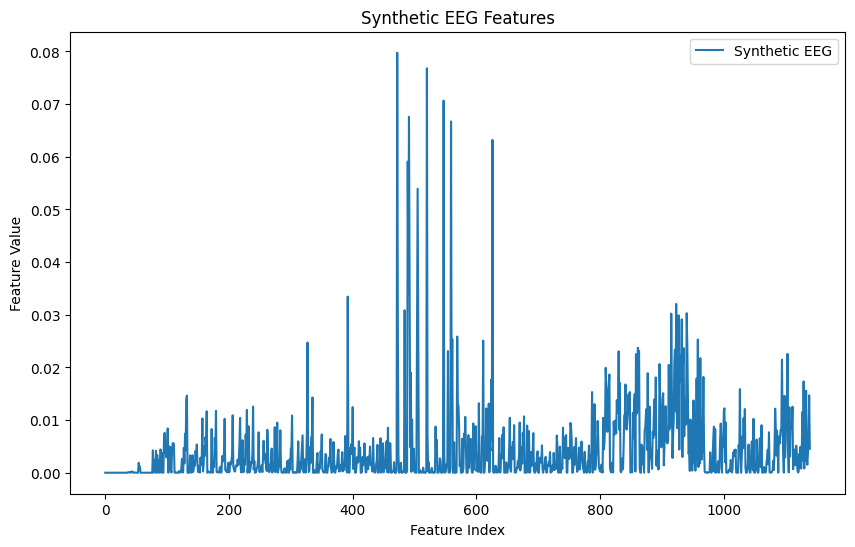

In [19]:
# generate synthetic data conditioned on a specific label
condition_label = np.zeros((1, y_train.shape[1]))
condition_label[0, 0] = 1  # condition on the first label
random_latent = np.random.normal(size=(1, latent_dim))
synthetic = cvae.decoder(tf.concat([random_latent, condition_label], axis=1))

# plot the generated EEG features
plt.figure(figsize=(10, 6))
plt.plot(synthetic.numpy().flatten(), label="Synthetic EEG")
plt.title("Synthetic EEG Features")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.legend()
plt.show()


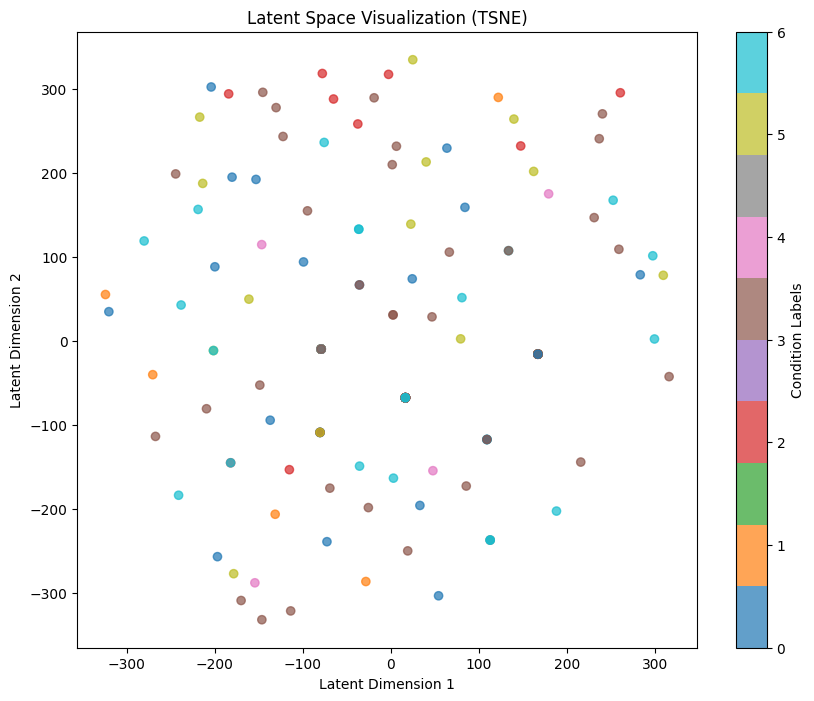

In [20]:
def visualize_latent_space(model, features, labels, reduction_method='tsne'):
    # encode features and labels
    conditioned_input = tf.concat([features, labels], axis=1)
    z_mean, _ = model.encoder(conditioned_input)
    latent_vectors = z_mean.numpy()
    label_indices = np.argmax(labels, axis=1)  # convert one-hot labels to integers

    # dimensionality reduction
    if reduction_method == 'tsne':
        reduced_latents = TSNE(n_components=2, random_state=42).fit_transform(latent_vectors)
    elif reduction_method == 'pca':
        reduced_latents = PCA(n_components=2).fit_transform(latent_vectors)
    else:
        raise ValueError("Invalid reduction_method. Choose 'tsne' or 'pca'.")

    # plot the latent Space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_latents[:, 0],
        reduced_latents[:, 1],
        c=label_indices,
        cmap='tab10',
        alpha=0.7
    )
    plt.colorbar(scatter, label="Condition Labels")
    plt.title(f"Latent Space Visualization ({reduction_method.upper()})")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.show()

visualize_latent_space(cvae, tf.convert_to_tensor(X_test, dtype=tf.float32),
                       tf.convert_to_tensor(y_test, dtype=tf.float32), reduction_method='tsne')


In [21]:
def compute_metrics(model, features, labels):
    # forward pass through the model
    reconstructed, z_mean, z_log_var = model(features, labels)

    # compute reconstruction loss (MSE)
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(features, reconstructed)).numpy()

    # compute KL divergence
    kl_divergence = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    kl_divergence = tf.reduce_mean(kl_divergence).numpy()

    # total loss
    total_loss = reconstruction_loss + kl_divergence

    # mean absolute error (MAE)
    mae = tf.reduce_mean(tf.abs(features - reconstructed)).numpy()

    # r-squared
    residuals = tf.reduce_sum(tf.square(features - reconstructed), axis=1)
    total_variance = tf.reduce_sum(tf.square(features - tf.reduce_mean(features, axis=0)), axis=1)
    r2 = 1 - tf.reduce_mean(residuals / total_variance).numpy()

    return {
        "Total Loss": total_loss,
        "Reconstruction Loss": reconstruction_loss,
        "KL Divergence": kl_divergence,
        "MAE": mae,
        "R²": r2
    }

metrics = compute_metrics(cvae, tf.convert_to_tensor(X_test, dtype=tf.float32),
                          tf.convert_to_tensor(y_test, dtype=tf.float32))
print("Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


Metrics:
Total Loss: 1.0718
Reconstruction Loss: 1.0625
KL Divergence: 0.0093
MAE: 0.7978
R²: -0.0084


In [29]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

def compute_dci_metrics(latent_representations, ground_truth_factors):
    """
    Compute DCI metrics: Disentanglement, Completeness, and Informativeness.

    Parameters:
        latent_representations (np.ndarray): The latent space representations (n_samples, n_latents).
        ground_truth_factors (np.ndarray): The ground truth factors (n_samples, n_factors).

    Returns:
        dict: A dictionary containing the DCI metrics: disentanglement, completeness, informativeness.
    """
    n_latents = latent_representations.shape[1]
    n_factors = ground_truth_factors.shape[1]

    # Standardize the latent representations
    scaler = StandardScaler()
    latent_representations = scaler.fit_transform(latent_representations)

    importance_matrix = np.zeros((n_latents, n_factors))

    # Train a logistic regression model for each factor
    for factor_idx in range(n_factors):
        y = ground_truth_factors[:, factor_idx]
        model = LogisticRegression(max_iter=1000)
        model.fit(latent_representations, y)
        importance_matrix[:, factor_idx] = np.abs(model.coef_).mean(axis=0)

    # Compute disentanglement
    disentanglement_scores = 1 - (importance_matrix / importance_matrix.sum(axis=0, keepdims=True)).std(axis=0)
    disentanglement = np.mean(disentanglement_scores)

    # Compute completeness
    completeness_scores = 1 - (importance_matrix / importance_matrix.sum(axis=1, keepdims=True)).std(axis=1)
    completeness = np.mean(completeness_scores)

    # Compute informativeness (average accuracy)
    accuracies = []
    for factor_idx in range(n_factors):
        y = ground_truth_factors[:, factor_idx]
        model = LogisticRegression(max_iter=1000)
        model.fit(latent_representations, y)
        y_pred = model.predict(latent_representations)
        accuracies.append(accuracy_score(y, y_pred))
    informativeness = np.mean(accuracies)

    return {
        "disentanglement": disentanglement,
        "completeness": completeness,
        "informativeness": informativeness
    }


In [30]:
# concatenate inputs and labels for the encoder
conditioned_input_test = tf.concat([X_test, y_test], axis=1)

# get latent representations (z_mean from the encoder)
z_mean, _ = cvae.encoder(conditioned_input_test)

# ensure z_mean is in NumPy format
latent_representations = z_mean.numpy()

# ground truth factors (e.g., labels)
ground_truth_factors = y_test

# compute DCI metrics
dci_metrics = compute_dci_metrics(latent_representations, ground_truth_factors)

# print the results
print("DCI Metrics:")
print("Disentanglement:", dci_metrics["disentanglement"])
print("Completeness:", dci_metrics["completeness"])
print("Informativeness:", dci_metrics["informativeness"])


DCI Metrics:
Disentanglement: 0.9264715232109746
Completeness: 0.8945287472006971
Informativeness: 0.8654572940287226
